In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
plt.rcParams['font.family'] = 'Microsoft JhengHei'


In [30]:
plant_name = '彰工'

資料讀取

In [31]:
df_mw = pd.read_csv(f'{plant_name}year_1h.csv')
df_weather = pd.read_csv('2024.csv')

# 處理時間欄位
df_mw['時間'] = pd.to_datetime(df_mw['date'] + ' ' + df_mw['time'].str.replace('_', ':'), format='%Y-%m-%d %H:%M')
df_weather['時間'] = pd.to_datetime(df_weather['時間'])

# 合併資料
df = pd.merge(df_mw[['MW', 'time', '時間']], df_weather, on='時間', how='inner')

# 去除 MW == -1 的資料
df = df[df['MW'] != -1]

# 移除非必要欄位 
df = df[[col for col in df.columns if '觀測狀態' not in col and col != '測站代號']]

# 補值
df.fillna(method='ffill', inplace=True)

# 時間特徵：hour
df['hour'] = df['time'].str.split('_').str[0].astype(int)




C:\Users\User\AppData\Local\Temp\ipykernel_2800\1460889641.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


特徵分析

Top 3 features: ['平均風風速(m/s)', '平均風風向(360 degree)', '測站氣壓(hPa)']


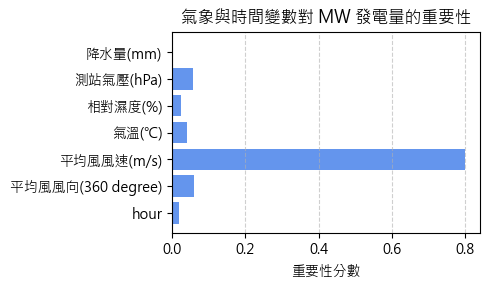

In [32]:
from sklearn.ensemble import RandomForestRegressor

features = ['降水量(mm)', '測站氣壓(hPa)', '相對濕度(%)', '氣溫(℃)', 
            '平均風風速(m/s)', '平均風風向(360 degree)', 'hour']
target = 'MW'

X = df[features]
y = df[target].values

scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)

X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.1, random_state=42)

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

importances = rf.feature_importances_

top3_idx = np.argsort(importances)[-3:][::-1]
top3_features = [features[i] for i in top3_idx]
print("Top 3 features:", top3_features)

plt.figure(figsize=(5,3))
plt.barh(features, importances, color='cornflowerblue')
plt.xlabel('重要性分數')
plt.title('氣象與時間變數對 MW 發電量的重要性')
plt.gca().invert_yaxis()
plt.grid(True, axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

時間序列

Epoch 1/10


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0494 - val_loss: 0.0540
Epoch 2/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0236 - val_loss: 0.0266
Epoch 3/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0206 - val_loss: 0.0271
Epoch 4/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0190 - val_loss: 0.0310
Epoch 5/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0176 - val_loss: 0.0302
Epoch 6/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0192 - val_loss: 0.0325
Epoch 7/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0173 - val_loss: 0.0341
Epoch 8/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0183 - val_loss: 0.0244
Epoch 9/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0180 - val_loss: 0.0257
Epoch 10/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0172 - val_loss: 0.0438
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
📉 NRMSE: 0.6517
🔍 R² score: 0.5752


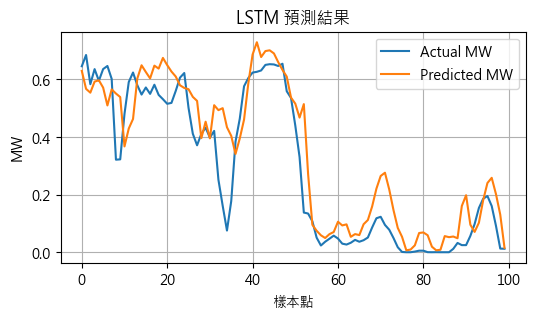

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

target = 'MW'

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(df[top3_features])
y_scaled = scaler_y.fit_transform(df[[target]])

window_size = 24
X_seq, y_seq = [], []
for i in range(window_size, len(X_scaled)):
    X_seq.append(X_scaled[i - window_size:i])
    y_seq.append(y_scaled[i])
X_seq = np.array(X_seq)
y_seq = np.array(y_seq)

X_train, X_val, y_train, y_val = train_test_split(X_seq, y_seq, test_size=0.1, shuffle=False)

model = Sequential([
    LSTM(64, input_shape=(window_size, len(top3_features)), return_sequences=False),
    Dense(32, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)

y_pred = model.predict(X_val)
y_pred_inv = scaler_y.inverse_transform(y_pred)
y_val_inv = scaler_y.inverse_transform(y_val)

rmse = np.sqrt(mean_squared_error(y_val_inv, y_pred_inv))
nrmse = rmse / np.std(y_val_inv)
r2 = r2_score(y_val_inv, y_pred_inv)
print(f"📉 NRMSE: {nrmse:.4f}")
print(f"🔍 R² score: {r2:.4f}")

plt.figure(figsize=(6, 3))
plt.plot(y_val[:100], label='Actual MW')
plt.plot(y_pred[:100], label='Predicted MW')
plt.legend()
plt.title('LSTM 預測結果')
plt.xlabel('樣本點')
plt.ylabel('MW')
plt.grid(True)
plt.show()


Xgboost

📉 NRMSE: 0.3435
🔍 R² score: 0.8820


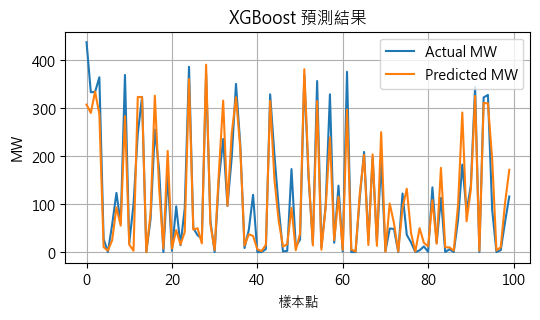

In [34]:
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor

weather_features = ['降水量(mm)', '測站氣壓(hPa)', '相對濕度(%)', '氣溫(℃)',
                    '平均風風速(m/s)', '平均風風向(360 degree)', 'hour']
target = 'MW'

X_all = df[weather_features]
y_all = df[target].values


X_top3 = df[top3_features]
y_final = y_all

scaler_X_top3 = MinMaxScaler()
X_top3_scaled = scaler_X_top3.fit_transform(X_top3)

X_train, X_val, y_train, y_val = train_test_split(X_top3_scaled, y_final, test_size=0.1, random_state=42)

xgb_model= XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_val)

rmse = np.sqrt(mean_squared_error(y_val, y_pred))
nrmse = rmse / np.std(y_val)
r2 = r2_score(y_val, y_pred)
print(f"📉 NRMSE: {nrmse:.4f}")
print(f"🔍 R² score: {r2:.4f}")

plt.figure(figsize=(6, 3))
plt.plot(y_val[:100], label='Actual MW')
plt.plot(y_pred[:100], label='Predicted MW')
plt.legend()
plt.title('XGBoost 預測結果')
plt.xlabel('樣本點')
plt.ylabel('MW')
plt.grid(True)
plt.show()



TabPFN

📉 NRMSE: 0.3794
🔍 R² score: 0.8561


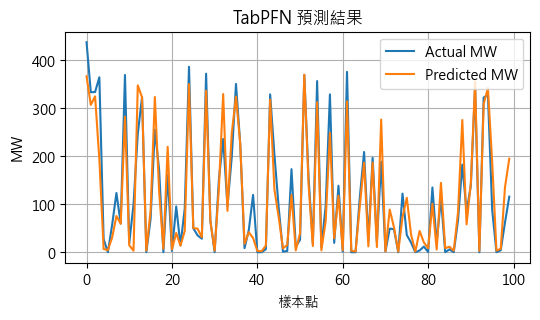

In [35]:
from tabpfn import TabPFNRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

weather_features = ['降水量(mm)', '測站氣壓(hPa)', '相對濕度(%)', '氣溫(℃)',
                    '平均風風速(m/s)', '平均風風向(360 degree)', 'hour']
target = 'MW'

X_all = df[weather_features]
y_all = df[target].values


X_top3 = df[top3_features]
y_final = y_all

scaler_X_top3 = MinMaxScaler()
X_top3_scaled = scaler_X_top3.fit_transform(X_top3)

X_train, X_val, y_train, y_val = train_test_split(X_top3_scaled, y_final, test_size=0.1, random_state=42)

TabPFN_model = TabPFNRegressor(device='cpu', ignore_pretraining_limits=True)

TabPFN_model.fit(X_train[:500], y_train[:500])

y_pred = TabPFN_model.predict(X_val)

rmse = np.sqrt(mean_squared_error(y_val, y_pred))
nrmse = rmse / np.std(y_val)
r2 = r2_score(y_val, y_pred)
print(f"📉 NRMSE: {nrmse:.4f}")
print(f"🔍 R² score: {r2:.4f}")


plt.figure(figsize=(6, 3))
plt.plot(y_val[:100], label='Actual MW')
plt.plot(y_pred[:100], label='Predicted MW')
plt.legend()
plt.title('TabPFN 預測結果')
plt.xlabel('樣本點')
plt.ylabel('MW')
plt.grid(True)
plt.show()


2025 一月測試

In [36]:
df_mw_202501 = pd.read_csv(f'{plant_name}202501.csv')
df_weather_202501 = pd.read_csv('202501.csv')

# 處理時間欄位
df_mw_202501['時間'] = pd.to_datetime(df_mw_202501['date'] + ' ' + df_mw_202501['time'].str.replace('_', ':'), format='%Y-%m-%d %H:%M')
df_weather_202501['時間'] = pd.to_datetime(df_weather_202501['時間'])

# 合併資料
df_202501 = pd.merge(df_mw_202501[['MW', 'time', '時間']], df_weather_202501, on='時間', how='inner')

# 時間特徵：hour
df_202501['hour'] = df_202501['time'].str.split('_').str[0].astype(int)

📉 NRMSE of xgb: 0.5079
🔍 R² score of xgb: 0.7420
📉 NRMSE of TabPFN: 0.5361
🔍 R² score of TabPFN: 0.7126


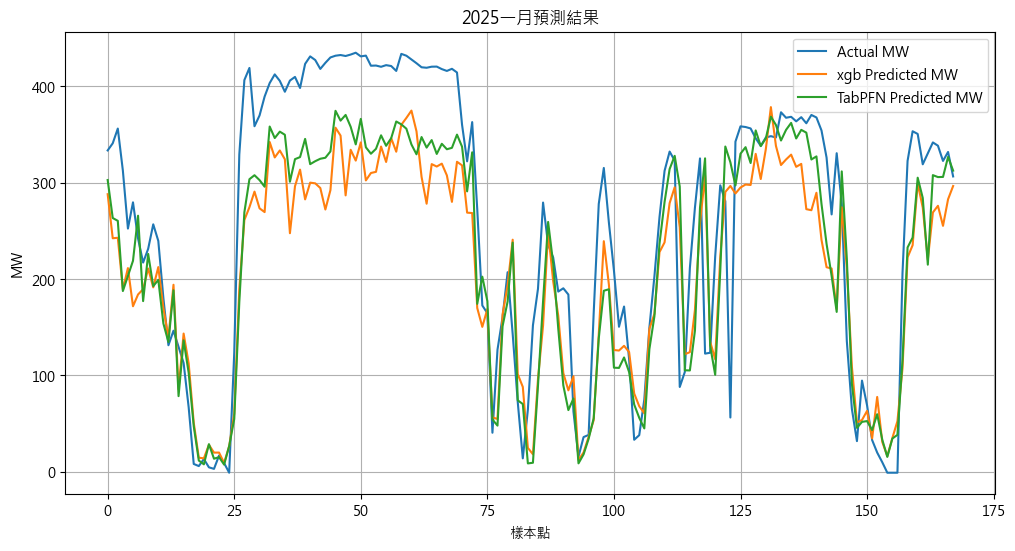

In [38]:
weather_features = ['降水量(mm)', '測站氣壓(hPa)', '相對濕度(%)', '氣溫(℃)',
                    '平均風風速(m/s)', '平均風風向(360 degree)', 'hour']
target = 'MW'

X_202501 = df_202501[top3_features]

X_202501_scaled = scaler_X_top3.transform(X_202501)

y_show = df_202501[target].values
y_xgb = xgb_model.predict(X_202501_scaled)
y_TabPFN = TabPFN_model.predict(X_202501_scaled)


rmse_xgb = np.sqrt(mean_squared_error(y_show, y_xgb))
nrmse_xgb = rmse_xgb  / np.std(y_show)
r2_xgb = r2_score(y_show, y_xgb)
print(f"📉 NRMSE of xgb: {nrmse_xgb:.4f}")
print(f"🔍 R² score of xgb: {r2_xgb:.4f}")

rmse_TabPFN = np.sqrt(mean_squared_error(y_show, y_TabPFN))
nrmse_TabPFN = rmse_TabPFN / np.std(y_show)
r2_TabPFN = r2_score(y_show, y_TabPFN)
print(f"📉 NRMSE of TabPFN: {nrmse_TabPFN :.4f}")
print(f"🔍 R² score of TabPFN: {r2_TabPFN :.4f}")

plt.figure(figsize=(12, 6))
plt.plot(y_show[:168], label='Actual MW')
plt.plot(y_xgb[:168], label='xgb Predicted MW')
plt.plot(y_TabPFN[:168], label='TabPFN Predicted MW')
plt.legend()
plt.title('2025一月預測結果')
plt.xlabel('樣本點')
plt.ylabel('MW')
plt.grid(True)
plt.show()
